## 0 - Importando bibliotecas necessárias

In [1]:
import salem
import xarray as xr
import geopandas as gp
import wget
import rioxarray
from rasterio.enums import Resampling
import pandas as pd
import matplotlib.pyplot as plt

## 1 - Fazendo o download do arquivo .grib2, lendo-o e convertendo-o para um netcdf

In [2]:
url = 'http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/2021/09/MERGE_CPTEC_20210904.grib2'
filename = wget.download(url)

data_grib = xr.open_dataset(filename, engine='cfgrib')
data_grib.to_netcdf('convertido.nc') #arquivo convertido em netcdf

100% [............................................................................] 387804 / 387804

## 2 - Lendo, recortando o arquivo netcdf de acordo com o shapefile da bacia do rio Tietê e salvando o resultado como um outro arquivo netcdf

In [3]:
################ lendo / preparando os arquivos para a operação de seleção da região de interesse #####################################

shape = salem.read_shapefile('tiete.shp')
shape = shape.dissolve(by='bacia') # disolvendo o shape inicial, que era formado por 4 geometrias

data = salem.open_xr_dataset('convertido.nc') #observe que originalmente o arquivo vem com a longitude de 0-360, vou então convertê-la para -180-180
data.coords['longitude'] = (data.coords['longitude'] + 180) % 360 - 180   
data = data.sortby(data.longitude) #dado já com a longitude corrigida

################ recortando os dados e salvando em um novo arquivo netcdf #############################################

data = data.salem.roi(shape = shape) # selecionando apenas os dados dentro da bacia
data = data.sel(latitude = slice(float(shape.bounds.miny.values-1),float(shape.bounds.maxy.values+1)), 
                longitude = slice(float(shape.bounds.minx.values-1),float(shape.bounds.maxx.values+1))) # aqui estou apenas diminuindo a área total do dataset, 
                                                                                                        # para que não salve tantos pontos mascarados fora da região de interesse

data.to_netcdf('bacia_interesse.nc') #salvando o dado com a região de interesse


## 3 - Reduzindo para metade da resolução original
#### Escolhi fazer isso com o arquivo recortado pela bacia, pois imaginei que faria mais sentido, mas pode também ser feito com os outros netcdfs, precisando apenas trocar o nome do arquivo

#### 3.1 - método 1: Utilizando o rasterio

Text(0.5, 1.0, 'Resampled método 1')

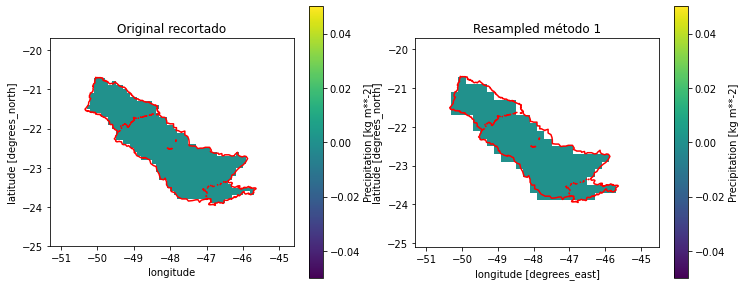

In [4]:
resample1 = xr.open_dataset("bacia_interesse.nc", decode_coords="all")
resample1.rio.write_crs("epsg:4326",inplace=True) # projeção =  wgs84 que é a que está listada no arquivo "bacia_interesse.nc"
resample1 = resample1.rio.reproject( resample1.rio.crs, resolution = 0.2, resampling=Resampling.bilinear)
resample1.to_netcdf('resample1.nc')

#### plotando
plt.figure(figsize = [12,5])
ax1 = plt.subplot(1,2,1)
data.prec.plot(ax = ax1)
shape.boundary.plot(ax = ax1, color = 'r')
plt.title('Original recortado')

ax2 = plt.subplot(1,2,2)
resample1.prec.plot(ax = ax2)
shape.boundary.plot(ax = ax2, color = 'r')
plt.title('Resampled método 1')

#### 3.2 - método 2: Utilizando o próprio xarray

Text(0.5, 1.0, 'Resampled método 2')

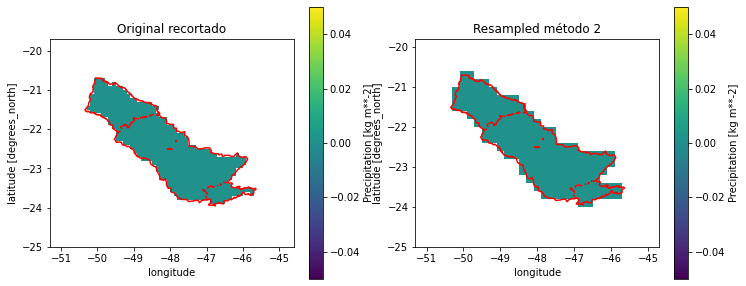

In [5]:
resample2 = xr.open_dataset("bacia_interesse.nc")
resample2 = resample2.coarsen(latitude=2, boundary = 'trim').mean().coarsen(longitude=2, boundary = 'trim').mean()
resample2.to_netcdf('resample2.nc')

#### plotando
plt.figure(figsize = [12,5])
ax1 = plt.subplot(1,2,1)
data.prec.plot(ax = ax1)
shape.boundary.plot(ax = ax1, color = 'r')
plt.title('Original recortado')

ax2 = plt.subplot(1,2,2)
resample2.prec.plot(ax = ax2)
shape.boundary.plot(ax = ax2, color = 'r')
plt.title('Resampled método 2')

## 4 - Criando e salvando a lista com todos os pontos de grade dentro da bacia de interesse

In [6]:
stacked = data.prec.stack(pontos=['latitude','longitude']) #stackando (em duplas) as coordenadas em uma mesma coordenada
pontos = stacked[stacked.notnull()].pontos.values #selecionado onde não é nan, ou seja, onde está dentro da área de interesse
pontos = pd.DataFrame(list(pontos), columns = ['latitude','longitude']) #transformando os pontos em dataframe

pontos.to_csv('pontos_dentro.csv')# salvando

pontos

,latitude,longitude
0,-23.85,-46.85
1,-23.85,-46.75
2,-23.85,-46.65
3,-23.85,-46.55
4,-23.75,-47.75
...,...,...
539,-20.85,-49.75
540,-20.85,-49.55
541,-20.75,-50.05
542,-20.75,-49.95
